# PEDIATRIC CHEST PNEUMONIA CLASSIFICATION

###Libraries

In [3]:
import os             
import cv2              
import tqdm            
import random
import pickle
import numpy as np      
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Constants**

In [5]:
# Dataset_Path = r'F:\Chest-Dataset\chest_xray'
Dataset_Path = r'/content/drive/MyDrive/University/#7th Semester/Machine Learning/Semester Project/chest_xray'
log_path = f'{Dataset_Path}/log/'
IMAGE_SIZE = 148
SPLIT_CODE = 43

# Utilities

In [6]:
def get_Data(path):
    X = []
    Y = []

    normal = os.path.join(path, "NORMAL")
    pneumonia = os.path.join(path, "PNEUMONIA")
    classes = [normal, pneumonia]
    for folder in classes:
        for file in tqdm(os.listdir(folder)):
            img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            X.append(img)
            Y.append(classes.index(folder))

    X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    X = np.array(X).astype('float')/255.0
    Y = np.array(Y)
    
    temp = list(zip(X, Y))
    random.Random(SPLIT_CODE).shuffle(temp)
    res1, res2 = zip(*temp)
    X, Y = np.array(list(res1)), np.array(list(res2))

    print(f'Pneumonia Found: {len(os.listdir(pneumonia))}')
    print(f'Normal Found: {len(os.listdir(normal))}')

    return X, Y

In [7]:
def show_train_vs_validation_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc', color='g')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
def save_data(path, data):
    pickle_out = open(path, "wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

In [9]:
def show_testing_score(actual, predicted, c_m = False):
    print(f'Accuracy: {accuracy_score(actual, predicted.round())}')
    print(f'Precision: {precision_score(actual, predicted.round())}')
    print(f'Recall: {recall_score(actual, predicted.round())}')
    print(f'F1-Score: {f1_score(actual, predicted.round())}')

    if(c_m):
        confusion_matrix_ = confusion_matrix(actual, predicted.round())
        cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = [False, True])
        cm_display.plot()
        plt.show()

In [10]:
def define_model(neurons, dense_layers, bn, dropouts):
  model = Sequential()
  
  for i, nodes in enumerate(neurons):
    if i == 0:
      model.add(Conv2D(nodes, (3, 3), input_shape=(IMAGE_SIZE,IMAGE_SIZE,1), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      if bn:
        model.add(BatchNormalization())
    else:
      model.add(Conv2D(nodes, (3, 3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  for i, nodes in enumerate(dense_layers):
    model.add(Dense(nodes, activation='relu'))
    if i < len(dropouts):
      model.add(Dropout(dropouts[i]))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
  return model

In [11]:
def Train_Model_and_Fine_Tune(name):
    neurons = [[32, 64], [32, 64, 128], [32, 64, 128, 128], [32, 64, 128, 256], [64, 128, 256, 256]]
    dense_layers = [[], [512], [256], [256, 256], [512, 256], [512, 512]]
    dropouts = [[0.2], [0.5], [0.2, 0.2], [0.2, 0.5], [0.5, 0.5]]
    bn = [True, False]
    for neuron in neurons:
        for dense_layer in dense_layers:
            for dropout in dropouts:
                for b in bn:
                    model = define_model(neuron, dense_layer, b, dropout)
                    history = model.fit(X_train, Y_train, epochs=15, batch_size=132, validation_data=(X_val, Y_val))
                    accuracy = accuracy_score(Y_test, model.predict(X_test).round())
                    print(f'neuron-{neuron}-dense-{dense_layer}-dropout-{dropout}-bach-{b}: {accuracy}')
                    model.save(f'{log_path}/{name}/neuron-{neuron}-dense-{dense_layer}-dropout-{dropout}-bach-{b}.h5')
                    model = None

In [12]:
def load_data(dataset_name):
    if dataset_name == 'Original':
        X, Y = get_Data(Dataset_Path + '/train')
    elif dataset_name == 'Augmented':
        X, Y = get_Data(Dataset_Path + '/train (augmented)')
    elif dataset_name == 'Generated':
        X, Y = get_Data(Dataset_Path + '/train (generated)')
    elif dataset_name == 'Augmented+Generated':
        X, Y = get_Data(Dataset_Path + '/train (augmented + generated)')
    else:
      print('Provided Invalid Data')
      return None

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=SPLIT_CODE, stratify=Y)
    X_test, Y_test = get_Data(Dataset_Path + '/test')
    print('Successfully Data loaded...!')
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Augmentation Section

In [ ]:
def perform_augmentation(name, img):
  datagen = ImageDataGenerator(rotation_range=35,
                              width_shift_range=0.1,
                              height_shift_range=0.08,
                              shear_range=0.2,
                              zoom_range=0.2)

  i = 0
  for batch in datagen.flow(img, batch_size=1):
    img = array_to_img(batch[0])
    path = os.path.join(Dataset_Augmented + "\\train\\Normal", f'{name[:-5]}-{i}.png')
    img.save(path)
    i += 1
    if i > 2:
      break
  return 2

In [ ]:
num = 0
normal = Dataset + "\\train\\NORMAL"
for file in tqdm(os.listdir(normal)):
    img = img_to_array(load_img(os.path.join(normal, file)))
    img = img.reshape((1, ) + img.shape)
    num += perform_augmentation(file, img)
    if num <= 2534:
        break

# GAN (GENERATIVE ADVERSERIAL NETWORK)

In [ ]:
generator = tf.keras.models.load_model('./generator-(Normal)-148x148.h5')

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_input (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 175232)            17698432  
                                                                 
 reshape (Reshape)           (None, 37, 37, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 37, 37, 128)      512       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 37, 37, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 74, 74, 128)      409728    
 nspose)                                                 

In [ ]:
num_of_images = 2534
noise_input = np.random.uniform(-1.0, 1.0, size=[num_of_images, 100])
x = generator.predict(noise_input)
x.shape

80/80 [==============================] - 221s 3s/step


(2534, 148, 148, 1)

In [ ]:
norm_image = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = np.array(norm_image.astype(np.uint8))

In [ ]:
path = r'./chest_xray/train (generated)/NORMAL/'

for i in tqdm(range(len(norm_image))):
    cv2.imwrite(path + f'generated-{i}.png', norm_image[i])

print('Successfully generated...!')

100%|██████████| 2534/2534 [00:04<00:00, 526.00it/s]

Successfully generated...!


# Classification on Imbalanced Data

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = load_data('Original')

100%|██████████| 3883/3883 [01:42<00:00, 37.96it/s] 


Pneumonia Found: 3883
Normal Found: 1349


100%|██████████| 390/390 [00:08<00:00, 47.32it/s] 


Pneumonia Found: 390
Normal Found: 234
Successfully Data loaded...!


In [ ]:
Train_Model_and_Fine_Tune('log(imbalance)')

Epoch 1/15
131/131 [==============================] - 13s 29ms/step - loss: 0.3042 - accuracy: 0.9168 - val_loss: 0.4570 - val_accuracy: 0.7440
Epoch 2/15
131/131 [==============================] - 3s 24ms/step - loss: 0.0756 - accuracy: 0.9701 - val_loss: 0.3585 - val_accuracy: 0.9245
Epoch 3/15
131/131 [==============================] - 3s 24ms/step - loss: 0.0511 - accuracy: 0.9814 - val_loss: 0.1902 - val_accuracy: 0.9484
Epoch 4/15
131/131 [==============================] - 3s 24ms/step - loss: 0.0222 - accuracy: 0.9909 - val_loss: 0.0741 - val_accuracy: 0.9704
Epoch 5/15
131/131 [==============================] - 3s 24ms/step - loss: 0.0182 - accuracy: 0.9928 - val_loss: 0.3036 - val_accuracy: 0.8997
Epoch 6/15
131/131 [==============================] - 3s 27ms/step - loss: 0.0184 - accuracy: 0.9928 - val_loss: 0.2579 - val_accuracy: 0.9255
Epoch 7/15
131/131 [==============================] - 3s 24ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0801 - val_accuracy: 0.977

In [ ]:
best_model = ['', 0]
models = []
path = f'{log_path}log(imbalance)'
for i in tqdm(os.listdir(path)):
  model = tf.keras.models.load_model(f'{path}/{i}')
  accuracy = accuracy_score(Y_test, model.predict(X_test).round())
  if accuracy > best_model[1]:
    best_model = [i, accuracy]
  models.append([i, accuracy])
  model = None

print(f'Best Model: {best_model}')

  0%|          | 0/155 [00:00<?, ?it/s]

20/20 [==============================] - 1s 11ms/step


  1%|          | 1/155 [00:01<04:02,  1.57s/it]

20/20 [==============================] - 0s 9ms/step


  1%|▏         | 2/155 [00:02<03:04,  1.21s/it]

20/20 [==============================] - 0s 10ms/step


  2%|▏         | 3/155 [00:04<03:27,  1.36s/it]

20/20 [==============================] - 0s 10ms/step


  3%|▎         | 4/155 [00:05<03:38,  1.45s/it]

20/20 [==============================] - 0s 10ms/step


  3%|▎         | 5/155 [00:06<02:46,  1.11s/it]

20/20 [==============================] - 0s 9ms/step


  4%|▍         | 6/155 [00:07<03:02,  1.23s/it]

20/20 [==============================] - 0s 10ms/step


  5%|▍         | 7/155 [00:09<03:19,  1.35s/it]

20/20 [==============================] - 0s 9ms/step


  5%|▌         | 8/155 [00:10<03:27,  1.41s/it]

20/20 [==============================] - 0s 10ms/step


  6%|▌         | 9/155 [00:12<03:32,  1.46s/it]

20/20 [==============================] - 0s 9ms/step


  6%|▋         | 10/155 [00:13<03:35,  1.49s/it]

20/20 [==============================] - 0s 10ms/step


  7%|▋         | 11/155 [00:24<10:25,  4.34s/it]

20/20 [==============================] - 0s 10ms/step


  8%|▊         | 12/155 [00:30<11:09,  4.68s/it]

20/20 [==============================] - 0s 11ms/step


  8%|▊         | 13/155 [00:37<13:14,  5.59s/it]

20/20 [==============================] - 0s 10ms/step


  9%|▉         | 14/155 [00:43<13:05,  5.57s/it]

20/20 [==============================] - 0s 11ms/step


 10%|▉         | 15/155 [00:48<12:49,  5.50s/it]

20/20 [==============================] - 0s 11ms/step


 10%|█         | 16/155 [00:54<13:09,  5.68s/it]

20/20 [==============================] - 0s 11ms/step


 11%|█         | 17/155 [01:01<13:37,  5.92s/it]

20/20 [==============================] - 0s 10ms/step


 12%|█▏        | 18/155 [01:07<13:49,  6.05s/it]

20/20 [==============================] - 0s 11ms/step


 12%|█▏        | 19/155 [01:14<14:23,  6.35s/it]

20/20 [==============================] - 0s 10ms/step


 13%|█▎        | 20/155 [01:20<14:15,  6.34s/it]

20/20 [==============================] - 0s 10ms/step


 14%|█▎        | 21/155 [01:24<12:07,  5.43s/it]

20/20 [==============================] - 0s 10ms/step


 14%|█▍        | 22/155 [01:28<11:27,  5.17s/it]

20/20 [==============================] - 0s 10ms/step


 15%|█▍        | 23/155 [01:32<10:21,  4.71s/it]

20/20 [==============================] - 0s 10ms/step


 15%|█▌        | 24/155 [01:36<10:05,  4.62s/it]

20/20 [==============================] - 0s 10ms/step


 16%|█▌        | 25/155 [01:40<09:11,  4.24s/it]

20/20 [==============================] - 0s 10ms/step


 17%|█▋        | 26/155 [01:43<08:33,  3.98s/it]

20/20 [==============================] - 0s 10ms/step


 17%|█▋        | 27/155 [01:47<08:26,  3.96s/it]

20/20 [==============================] - 0s 11ms/step


 18%|█▊        | 28/155 [01:51<08:20,  3.94s/it]

20/20 [==============================] - 0s 10ms/step


 19%|█▊        | 29/155 [01:54<07:58,  3.80s/it]

20/20 [==============================] - 0s 10ms/step


 19%|█▉        | 30/155 [01:58<07:35,  3.64s/it]

20/20 [==============================] - 0s 10ms/step


 20%|██        | 31/155 [02:01<07:37,  3.69s/it]

20/20 [==============================] - 0s 10ms/step


 21%|██        | 32/155 [02:05<07:18,  3.56s/it]

20/20 [==============================] - 0s 10ms/step


 21%|██▏       | 33/155 [02:08<07:13,  3.55s/it]

20/20 [==============================] - 0s 10ms/step


 22%|██▏       | 34/155 [02:13<08:10,  4.05s/it]

20/20 [==============================] - 0s 10ms/step


 23%|██▎       | 35/155 [02:19<08:49,  4.41s/it]

20/20 [==============================] - 0s 10ms/step


 23%|██▎       | 36/155 [02:23<08:56,  4.51s/it]

20/20 [==============================] - 0s 10ms/step


 24%|██▍       | 37/155 [02:27<08:24,  4.28s/it]

20/20 [==============================] - 0s 10ms/step


 25%|██▍       | 38/155 [02:31<07:50,  4.02s/it]

20/20 [==============================] - 0s 10ms/step


 25%|██▌       | 39/155 [02:34<07:20,  3.80s/it]

20/20 [==============================] - 0s 10ms/step


 26%|██▌       | 40/155 [02:37<07:02,  3.68s/it]

20/20 [==============================] - 0s 11ms/step


 26%|██▋       | 41/155 [02:46<09:43,  5.12s/it]

20/20 [==============================] - 0s 10ms/step


 27%|██▋       | 42/155 [02:52<10:21,  5.50s/it]

20/20 [==============================] - 0s 11ms/step


 28%|██▊       | 43/155 [03:01<12:11,  6.53s/it]

20/20 [==============================] - 0s 11ms/step


 28%|██▊       | 44/155 [03:07<11:29,  6.21s/it]

20/20 [==============================] - 0s 11ms/step


 29%|██▉       | 45/155 [03:13<11:39,  6.36s/it]

20/20 [==============================] - 0s 11ms/step


 30%|██▉       | 46/155 [03:19<11:12,  6.17s/it]

20/20 [==============================] - 0s 11ms/step


 30%|███       | 47/155 [03:26<11:32,  6.41s/it]

20/20 [==============================] - 0s 12ms/step


 31%|███       | 48/155 [03:33<11:29,  6.44s/it]

20/20 [==============================] - 0s 11ms/step


 32%|███▏      | 49/155 [03:39<11:12,  6.34s/it]

20/20 [==============================] - 0s 10ms/step


 32%|███▏      | 50/155 [03:44<10:29,  5.99s/it]

20/20 [==============================] - 0s 11ms/step


 33%|███▎      | 51/155 [03:50<10:38,  6.14s/it]

20/20 [==============================] - 0s 11ms/step


 34%|███▎      | 52/155 [03:57<10:37,  6.19s/it]

20/20 [==============================] - 0s 11ms/step


 34%|███▍      | 53/155 [04:02<10:06,  5.95s/it]

20/20 [==============================] - 0s 10ms/step


 35%|███▍      | 54/155 [04:07<09:39,  5.74s/it]

20/20 [==============================] - 0s 11ms/step


 35%|███▌      | 55/155 [04:13<09:24,  5.65s/it]

20/20 [==============================] - 0s 11ms/step


 36%|███▌      | 56/155 [04:20<10:04,  6.11s/it]

20/20 [==============================] - 0s 11ms/step


 37%|███▋      | 57/155 [04:26<09:47,  5.99s/it]

20/20 [==============================] - 0s 11ms/step


 37%|███▋      | 58/155 [04:31<09:39,  5.97s/it]

20/20 [==============================] - 0s 11ms/step


 38%|███▊      | 59/155 [04:37<09:27,  5.91s/it]

20/20 [==============================] - 0s 11ms/step


 39%|███▊      | 60/155 [04:44<09:32,  6.02s/it]

20/20 [==============================] - 0s 12ms/step


 39%|███▉      | 61/155 [04:45<07:26,  4.75s/it]

20/20 [==============================] - 0s 11ms/step


 40%|████      | 62/155 [04:48<06:16,  4.05s/it]

20/20 [==============================] - 0s 11ms/step


 41%|████      | 63/155 [04:49<05:07,  3.34s/it]

20/20 [==============================] - 0s 11ms/step


 41%|████▏     | 64/155 [04:51<04:23,  2.90s/it]

20/20 [==============================] - 0s 11ms/step


 42%|████▏     | 65/155 [04:53<03:45,  2.50s/it]

20/20 [==============================] - 0s 11ms/step


 43%|████▎     | 66/155 [04:54<03:17,  2.22s/it]

20/20 [==============================] - 0s 11ms/step


 43%|████▎     | 67/155 [04:56<02:57,  2.02s/it]

20/20 [==============================] - 0s 10ms/step


 44%|████▍     | 68/155 [04:58<02:44,  1.90s/it]

20/20 [==============================] - 0s 11ms/step


 45%|████▍     | 69/155 [04:59<02:40,  1.86s/it]

20/20 [==============================] - 0s 10ms/step


 45%|████▌     | 70/155 [05:01<02:33,  1.81s/it]

20/20 [==============================] - 0s 12ms/step


 46%|████▌     | 71/155 [05:07<04:09,  2.97s/it]

20/20 [==============================] - 0s 11ms/step


 46%|████▋     | 72/155 [05:10<04:24,  3.19s/it]

20/20 [==============================] - 0s 12ms/step


 47%|████▋     | 73/155 [05:14<04:42,  3.44s/it]

20/20 [==============================] - 0s 12ms/step


 48%|████▊     | 74/155 [05:18<04:52,  3.61s/it]

20/20 [==============================] - 0s 12ms/step


 48%|████▊     | 75/155 [05:22<04:43,  3.54s/it]

20/20 [==============================] - 0s 11ms/step


 49%|████▉     | 76/155 [05:25<04:34,  3.47s/it]

20/20 [==============================] - 0s 12ms/step


 50%|████▉     | 77/155 [05:29<04:37,  3.56s/it]

20/20 [==============================] - 0s 12ms/step


 50%|█████     | 78/155 [05:33<04:37,  3.60s/it]

20/20 [==============================] - 0s 12ms/step


 51%|█████     | 79/155 [05:37<04:48,  3.80s/it]

20/20 [==============================] - 0s 12ms/step


 52%|█████▏    | 80/155 [05:41<04:58,  3.98s/it]

20/20 [==============================] - 0s 11ms/step


 52%|█████▏    | 81/155 [05:44<04:29,  3.64s/it]

20/20 [==============================] - 0s 11ms/step


 53%|█████▎    | 82/155 [05:46<03:57,  3.25s/it]

20/20 [==============================] - 0s 12ms/step


 54%|█████▎    | 83/155 [05:49<03:35,  2.99s/it]

20/20 [==============================] - 0s 11ms/step


 54%|█████▍    | 84/155 [05:51<03:19,  2.82s/it]

20/20 [==============================] - 0s 12ms/step


 55%|█████▍    | 85/155 [05:54<03:09,  2.70s/it]

20/20 [==============================] - 0s 11ms/step


 55%|█████▌    | 86/155 [05:56<03:03,  2.66s/it]

20/20 [==============================] - 0s 11ms/step


 56%|█████▌    | 87/155 [05:59<02:55,  2.58s/it]

20/20 [==============================] - 0s 11ms/step


 57%|█████▋    | 88/155 [06:02<03:12,  2.87s/it]

20/20 [==============================] - 0s 11ms/step


 57%|█████▋    | 89/155 [06:05<02:59,  2.72s/it]

20/20 [==============================] - 0s 11ms/step


 58%|█████▊    | 90/155 [06:07<02:50,  2.62s/it]

20/20 [==============================] - 0s 11ms/step


 59%|█████▊    | 91/155 [06:10<02:49,  2.64s/it]

20/20 [==============================] - 0s 11ms/step


 59%|█████▉    | 92/155 [06:12<02:46,  2.65s/it]

20/20 [==============================] - 0s 11ms/step


 60%|██████    | 93/155 [06:15<02:39,  2.58s/it]

20/20 [==============================] - 0s 11ms/step


 61%|██████    | 94/155 [06:17<02:32,  2.50s/it]

20/20 [==============================] - 0s 12ms/step


 61%|██████▏   | 95/155 [06:20<02:31,  2.53s/it]

20/20 [==============================] - 0s 11ms/step


 62%|██████▏   | 96/155 [06:22<02:28,  2.51s/it]

20/20 [==============================] - 0s 11ms/step


 63%|██████▎   | 97/155 [06:24<02:23,  2.47s/it]

20/20 [==============================] - 0s 11ms/step


 63%|██████▎   | 98/155 [06:27<02:18,  2.42s/it]

20/20 [==============================] - 0s 12ms/step


 64%|██████▍   | 99/155 [06:30<02:22,  2.55s/it]

20/20 [==============================] - 0s 11ms/step


 65%|██████▍   | 100/155 [06:32<02:17,  2.49s/it]

20/20 [==============================] - 0s 12ms/step


 65%|██████▌   | 101/155 [06:35<02:27,  2.73s/it]

20/20 [==============================] - 0s 12ms/step


 66%|██████▌   | 102/155 [06:39<02:33,  2.89s/it]

20/20 [==============================] - 0s 12ms/step


 66%|██████▋   | 103/155 [06:42<02:33,  2.96s/it]

20/20 [==============================] - 0s 12ms/step


 67%|██████▋   | 104/155 [06:45<02:31,  2.97s/it]

20/20 [==============================] - 0s 12ms/step


 68%|██████▊   | 105/155 [06:48<02:32,  3.04s/it]

20/20 [==============================] - 0s 12ms/step


 68%|██████▊   | 106/155 [06:52<02:42,  3.32s/it]

20/20 [==============================] - 0s 12ms/step


 69%|██████▉   | 107/155 [06:55<02:37,  3.29s/it]

20/20 [==============================] - 0s 11ms/step


 70%|██████▉   | 108/155 [06:58<02:35,  3.30s/it]

20/20 [==============================] - 0s 12ms/step


 70%|███████   | 109/155 [07:02<02:38,  3.45s/it]

20/20 [==============================] - 0s 12ms/step


 71%|███████   | 110/155 [07:06<02:41,  3.59s/it]

20/20 [==============================] - 0s 12ms/step


 72%|███████▏  | 111/155 [07:10<02:40,  3.64s/it]

20/20 [==============================] - 0s 12ms/step


 72%|███████▏  | 112/155 [07:14<02:41,  3.75s/it]

20/20 [==============================] - 0s 12ms/step


 73%|███████▎  | 113/155 [07:18<02:36,  3.72s/it]

20/20 [==============================] - 0s 12ms/step


 74%|███████▎  | 114/155 [07:22<02:47,  4.10s/it]

20/20 [==============================] - 0s 12ms/step


 74%|███████▍  | 115/155 [07:27<02:43,  4.09s/it]

20/20 [==============================] - 0s 11ms/step


 75%|███████▍  | 116/155 [07:30<02:28,  3.80s/it]

20/20 [==============================] - 0s 12ms/step


 75%|███████▌  | 117/155 [07:33<02:16,  3.60s/it]

20/20 [==============================] - 0s 12ms/step


 76%|███████▌  | 118/155 [07:36<02:10,  3.52s/it]

20/20 [==============================] - 0s 12ms/step


 77%|███████▋  | 119/155 [07:41<02:17,  3.81s/it]

20/20 [==============================] - 0s 11ms/step


 77%|███████▋  | 120/155 [07:44<02:05,  3.59s/it]

20/20 [==============================] - 0s 13ms/step


 78%|███████▊  | 121/155 [07:46<01:47,  3.17s/it]

20/20 [==============================] - 0s 11ms/step


 79%|███████▊  | 122/155 [07:48<01:29,  2.72s/it]

20/20 [==============================] - 0s 11ms/step


 79%|███████▉  | 123/155 [07:49<01:17,  2.41s/it]

20/20 [==============================] - 0s 11ms/step


 80%|████████  | 124/155 [07:51<01:07,  2.19s/it]

20/20 [==============================] - 0s 12ms/step


 81%|████████  | 125/155 [07:53<01:03,  2.13s/it]

20/20 [==============================] - 0s 11ms/step


 81%|████████▏ | 126/155 [07:55<00:58,  2.03s/it]

20/20 [==============================] - 0s 11ms/step


 82%|████████▏ | 127/155 [07:57<00:55,  1.98s/it]

20/20 [==============================] - 0s 12ms/step


 83%|████████▎ | 128/155 [07:59<00:55,  2.04s/it]

20/20 [==============================] - 0s 11ms/step


 83%|████████▎ | 129/155 [08:00<00:49,  1.92s/it]

20/20 [==============================] - 0s 11ms/step


 84%|████████▍ | 130/155 [08:02<00:46,  1.88s/it]

20/20 [==============================] - 0s 12ms/step


 85%|████████▍ | 131/155 [08:04<00:46,  1.96s/it]

20/20 [==============================] - 0s 12ms/step


 85%|████████▌ | 132/155 [08:08<00:57,  2.49s/it]

20/20 [==============================] - 0s 12ms/step


 86%|████████▌ | 133/155 [08:13<01:08,  3.11s/it]

20/20 [==============================] - 0s 12ms/step


 86%|████████▋ | 134/155 [08:15<01:01,  2.91s/it]

20/20 [==============================] - 0s 12ms/step


 87%|████████▋ | 135/155 [08:17<00:52,  2.65s/it]

20/20 [==============================] - 0s 12ms/step


 88%|████████▊ | 136/155 [08:19<00:48,  2.55s/it]

20/20 [==============================] - 0s 11ms/step


 88%|████████▊ | 137/155 [08:21<00:42,  2.38s/it]

20/20 [==============================] - 0s 12ms/step


 89%|████████▉ | 138/155 [08:24<00:39,  2.35s/it]

20/20 [==============================] - 0s 12ms/step


 90%|████████▉ | 139/155 [08:26<00:36,  2.28s/it]

20/20 [==============================] - 0s 12ms/step


 90%|█████████ | 140/155 [08:28<00:32,  2.19s/it]

20/20 [==============================] - 0s 11ms/step


 91%|█████████ | 141/155 [08:30<00:29,  2.08s/it]

20/20 [==============================] - 0s 11ms/step


 92%|█████████▏| 142/155 [08:32<00:26,  2.03s/it]

20/20 [==============================] - 0s 11ms/step


 92%|█████████▏| 143/155 [08:33<00:23,  2.00s/it]

20/20 [==============================] - 0s 11ms/step


 93%|█████████▎| 144/155 [08:35<00:21,  1.96s/it]

20/20 [==============================] - 0s 11ms/step


 94%|█████████▎| 145/155 [08:37<00:19,  1.93s/it]

20/20 [==============================] - 0s 11ms/step


 94%|█████████▍| 146/155 [08:39<00:17,  1.91s/it]

20/20 [==============================] - 0s 12ms/step


 95%|█████████▍| 147/155 [08:41<00:15,  1.92s/it]

20/20 [==============================] - 0s 11ms/step


 95%|█████████▌| 148/155 [08:43<00:13,  1.91s/it]

20/20 [==============================] - 0s 11ms/step


 96%|█████████▌| 149/155 [08:45<00:11,  1.87s/it]

20/20 [==============================] - 0s 12ms/step


 97%|█████████▋| 150/155 [08:47<00:10,  2.02s/it]

20/20 [==============================] - 0s 11ms/step


 97%|█████████▋| 151/155 [08:49<00:08,  2.01s/it]

20/20 [==============================] - 0s 12ms/step


 98%|█████████▊| 152/155 [08:51<00:06,  2.07s/it]

20/20 [==============================] - 0s 11ms/step


 99%|█████████▊| 153/155 [08:53<00:04,  2.01s/it]

20/20 [==============================] - 0s 11ms/step


 99%|█████████▉| 154/155 [08:55<00:01,  1.97s/it]

20/20 [==============================] - 0s 11ms/step


100%|██████████| 155/155 [08:57<00:00,  3.47s/it]

Best Model: ['neuron-[32, 64, 128, 128]-dense-[]-dropout-[0.2, 0.2]-bach-False.h5', 0.8141025641025641]


In [ ]:
sorted_model = sorted(models,key=lambda models:models[1], reverse=True)
print(sorted_model)
print(f'Best Models: {sorted_model[:3]}')

Best Models: [['neuron-[32, 64, 128, 128]-dense-[]-dropout-[0.2, 0.2]-bach-False.h5', 0.8141025641025641], ['neuron-[32, 64, 128, 128]-dense-[256]-dropout-[0.5]-bach-False.h5', 0.8108974358974359], ['neuron-[32, 64, 128]-dense-[256, 256]-dropout-[0.5, 0.5]-bach-True.h5', 0.8076923076923077]]


In [ ]:
model = define_model([32, 64, 128, 128], [256], False, [0.5])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 146, 146, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 33, 33, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 128)     

In [ ]:
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
131/131 [==============================] - 5s 34ms/step - loss: 0.4046 - accuracy: 0.8239 - val_loss: 0.1441 - val_accuracy: 0.9436
Epoch 2/50
131/131 [==============================] - 4s 29ms/step - loss: 0.1553 - accuracy: 0.9415 - val_loss: 0.1243 - val_accuracy: 0.9503
Epoch 3/50
131/131 [==============================] - 4s 31ms/step - loss: 0.1143 - accuracy: 0.9572 - val_loss: 0.0682 - val_accuracy: 0.9723
Epoch 4/50
131/131 [==============================] - 4s 29ms/step - loss: 0.1001 - accuracy: 0.9637 - val_loss: 0.0573 - val_accuracy: 0.9790
Epoch 5/50
131/131 [==============================] - 4s 29ms/step - loss: 0.0715 - accuracy: 0.9732 - val_loss: 0.0811 - val_accuracy: 0.9704
Epoch 6/50
131/131 [==============================] - 4s 29ms/step - loss: 0.0819 - accuracy: 0.9704 - val_loss: 0.0685 - val_accuracy: 0.9761
Epoch 7/50
131/131 [==============================] - 4s 31ms/step - loss: 0.0565 - accuracy: 0.9773 - val_loss: 0.0723 - val_accuracy: 0.9742

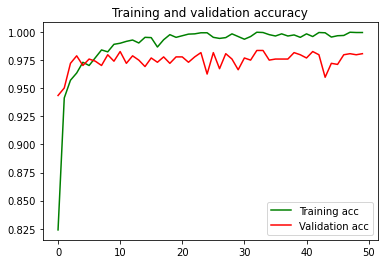

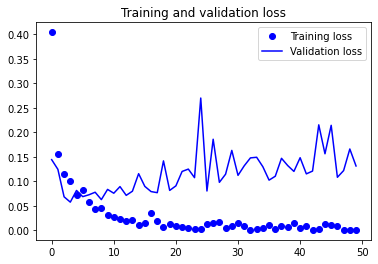

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

20/20 [==============================] - 1s 16ms/step
Accuracy: 0.7676282051282052
Precision: 0.7289719626168224
Recall: 1.0
F1-Score: 0.8432432432432433


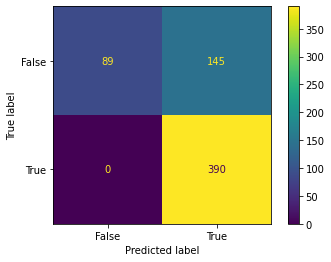

In [ ]:
predicted = model.predict(X_test)
show_testing_score(Y_test, predicted.round(), True)

# Classification on Balance Data using Augmentation

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = load_data('Augmented')

100%|██████████| 3883/3883 [01:36<00:00, 40.25it/s] 


Pneumonia Found: 3883
Normal Found: 3883


100%|██████████| 390/390 [00:06<00:00, 58.94it/s] 


Pneumonia Found: 390
Normal Found: 234
Successfully Data loaded...!


In [ ]:
Train_Model_and_Fine_Tune('log(augmented)')

Epoch 1/15
195/195 [==============================] - 7s 27ms/step - loss: 0.2924 - accuracy: 0.9139 - val_loss: 0.5975 - val_accuracy: 0.8314
Epoch 2/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0790 - accuracy: 0.9713 - val_loss: 0.3853 - val_accuracy: 0.8835
Epoch 3/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0493 - accuracy: 0.9828 - val_loss: 0.1424 - val_accuracy: 0.9505
Epoch 4/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0269 - accuracy: 0.9911 - val_loss: 0.1381 - val_accuracy: 0.9498
Epoch 5/15
195/195 [==============================] - 5s 25ms/step - loss: 0.0283 - accuracy: 0.9894 - val_loss: 1.0358 - val_accuracy: 0.7600
Epoch 6/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.1201 - val_accuracy: 0.9646
Epoch 7/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.1399 - val_accuracy: 0.9665

In [ ]:
print('Best Model: neuron-[32, 64]-dense-[512, 256]-dropout-[0.2, 0.5]-bach-True: 0.8605769230769231')

Best Model: neuron-[32, 64]-dense-[512, 256]-dropout-[0.2, 0.5]-bach-True: 0.8605769230769231


In [ ]:
model = define_model([16, 32, 128], [256, 512], True, [0.2, 0.5])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 146, 146, 16)      160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 73, 73, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 71, 71, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                      

In [ ]:
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val))

Epoch 1/50
195/195 [==============================] - 5s 23ms/step - loss: 0.2908 - accuracy: 0.8915 - val_loss: 1.1608 - val_accuracy: 0.5006
Epoch 2/50
195/195 [==============================] - 4s 22ms/step - loss: 0.1067 - accuracy: 0.9641 - val_loss: 0.8197 - val_accuracy: 0.6461
Epoch 3/50
195/195 [==============================] - 4s 20ms/step - loss: 0.0657 - accuracy: 0.9765 - val_loss: 0.1736 - val_accuracy: 0.9344
Epoch 4/50
195/195 [==============================] - 4s 22ms/step - loss: 0.0477 - accuracy: 0.9833 - val_loss: 0.1127 - val_accuracy: 0.9607
Epoch 5/50
195/195 [==============================] - 4s 21ms/step - loss: 0.0345 - accuracy: 0.9878 - val_loss: 0.1223 - val_accuracy: 0.9556
Epoch 6/50
195/195 [==============================] - 4s 21ms/step - loss: 0.0359 - accuracy: 0.9865 - val_loss: 0.1459 - val_accuracy: 0.9595
Epoch 7/50
195/195 [==============================] - 4s 20ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 0.1823 - val_accuracy: 0.9620

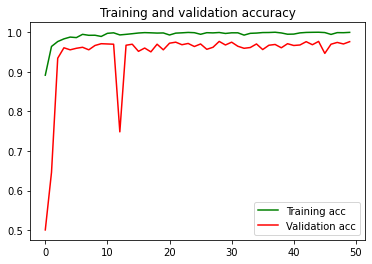

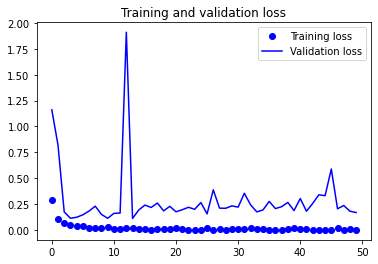

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

20/20 [==============================] - 0s 6ms/step
Accuracy: 0.8060897435897436
Precision: 0.7684630738522954
Recall: 0.9871794871794872
F1-Score: 0.8641975308641975


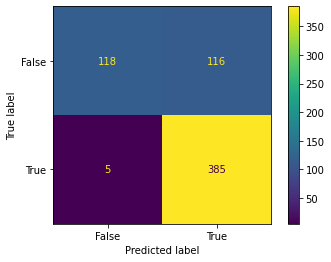

In [ ]:
Y_predict = model.predict(X_test)
show_testing_score(Y_test, Y_predict, True)

# Classification on Balance Data using GAN (Generative Adversarial Network)

In [ ]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = load_data('Generated')

100%|██████████| 3883/3883 [01:24<00:00, 46.11it/s] 


Pneumonia Found: 3883
Normal Found: 3883


100%|██████████| 390/390 [00:03<00:00, 121.44it/s]


Pneumonia Found: 390
Normal Found: 234
Successfully Data loaded...!


In [ ]:
Train_Model_and_Fine_Tune('log(generated)')

Epoch 1/15
195/195 [==============================] - 6s 26ms/step - loss: 0.1682 - accuracy: 0.9488 - val_loss: 0.4085 - val_accuracy: 0.8745
Epoch 2/15
195/195 [==============================] - 5s 26ms/step - loss: 0.0507 - accuracy: 0.9823 - val_loss: 0.1473 - val_accuracy: 0.9723
Epoch 3/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0409 - accuracy: 0.9847 - val_loss: 0.1309 - val_accuracy: 0.9550
Epoch 4/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0297 - accuracy: 0.9863 - val_loss: 0.0950 - val_accuracy: 0.9710
Epoch 5/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 0.0558 - val_accuracy: 0.9794
Epoch 6/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.1093 - val_accuracy: 0.9646
Epoch 7/15
195/195 [==============================] - 5s 24ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0631 - val_accuracy: 0.9781

In [ ]:
best_model = ['', 0]
models = []
path = f'{log_path}log(generated)'
for i in tqdm(os.listdir(path)):
  model = tf.keras.models.load_model(f'{path}/{i}')
  accuracy = accuracy_score(Y_test, model.predict(X_test).round())
  if accuracy > best_model[1]:
    best_model = [i, accuracy]
  models.append([i, accuracy])
  model = None

print(f'Best Model: {best_model}')

  0%|          | 0/30 [00:00<?, ?it/s]

20/20 [==============================] - 8s 15ms/step


  3%|▎         | 1/30 [00:12<05:50, 12.09s/it]

20/20 [==============================] - 0s 10ms/step


  7%|▋         | 2/30 [00:13<02:37,  5.63s/it]

20/20 [==============================] - 0s 10ms/step


 10%|█         | 3/30 [00:14<01:40,  3.72s/it]

20/20 [==============================] - 0s 9ms/step


 13%|█▎        | 4/30 [00:15<01:10,  2.70s/it]

20/20 [==============================] - 0s 9ms/step


 17%|█▋        | 5/30 [00:17<00:54,  2.19s/it]

20/20 [==============================] - 0s 10ms/step


 20%|██        | 6/30 [00:18<00:45,  1.90s/it]

20/20 [==============================] - 0s 10ms/step


 23%|██▎       | 7/30 [00:19<00:39,  1.72s/it]

20/20 [==============================] - 0s 9ms/step


 27%|██▋       | 8/30 [00:20<00:34,  1.56s/it]

20/20 [==============================] - 0s 10ms/step


 30%|███       | 9/30 [00:22<00:29,  1.40s/it]

20/20 [==============================] - 0s 9ms/step


 33%|███▎      | 10/30 [00:23<00:25,  1.29s/it]

20/20 [==============================] - 0s 11ms/step


 37%|███▋      | 11/30 [00:35<01:26,  4.55s/it]

20/20 [==============================] - 0s 10ms/step


 40%|████      | 12/30 [00:50<02:22,  7.90s/it]

20/20 [==============================] - 0s 11ms/step


 43%|████▎     | 13/30 [01:01<02:29,  8.77s/it]

20/20 [==============================] - 0s 11ms/step


 47%|████▋     | 14/30 [01:16<02:50, 10.65s/it]

20/20 [==============================] - 0s 11ms/step


 50%|█████     | 15/30 [01:27<02:43, 10.87s/it]

20/20 [==============================] - 0s 11ms/step


 53%|█████▎    | 16/30 [01:36<02:21, 10.12s/it]

20/20 [==============================] - 0s 11ms/step


 57%|█████▋    | 17/30 [01:43<01:59,  9.16s/it]

20/20 [==============================] - 0s 11ms/step


 60%|██████    | 18/30 [01:51<01:46,  8.85s/it]

20/20 [==============================] - 0s 11ms/step


 63%|██████▎   | 19/30 [02:01<01:41,  9.23s/it]

20/20 [==============================] - 0s 10ms/step


 67%|██████▋   | 20/30 [02:10<01:31,  9.20s/it]

20/20 [==============================] - 0s 10ms/step


 70%|███████   | 21/30 [02:15<01:11,  7.89s/it]

20/20 [==============================] - 0s 10ms/step


 73%|███████▎  | 22/30 [02:19<00:55,  6.88s/it]

20/20 [==============================] - 0s 10ms/step


 77%|███████▋  | 23/30 [02:26<00:46,  6.69s/it]

20/20 [==============================] - 0s 10ms/step


 80%|████████  | 24/30 [02:38<00:51,  8.51s/it]

20/20 [==============================] - 0s 10ms/step


 83%|████████▎ | 25/30 [02:43<00:36,  7.39s/it]

20/20 [==============================] - 0s 10ms/step


 87%|████████▋ | 26/30 [02:47<00:25,  6.43s/it]

20/20 [==============================] - 0s 10ms/step


 90%|█████████ | 27/30 [02:51<00:17,  5.77s/it]

20/20 [==============================] - 0s 10ms/step


 93%|█████████▎| 28/30 [02:56<00:10,  5.44s/it]

20/20 [==============================] - 0s 10ms/step


 97%|█████████▋| 29/30 [03:02<00:05,  5.61s/it]

20/20 [==============================] - 0s 10ms/step


100%|██████████| 30/30 [03:06<00:00,  6.21s/it]

Best Model: ['neuron-[32, 64]-dense-[512]-dropout-[0.2, 0.5]-bach-True.h5', 0.8413461538461539]


In [ ]:
print(f'Best Model: {best_model}')

Best Model: ['neuron-[32, 64]-dense-[512]-dropout-[0.2, 0.5]-bach-True.h5', 0.8413461538461539]


In [ ]:
model = define_model([32, 64], [512], False, [0.2])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 78400)             0         
                                                                 
 dense (Dense)               (None, 512)               4

In [ ]:
history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val))

Epoch 1/15
195/195 [==============================] - 7s 33ms/step - loss: 0.3021 - accuracy: 0.8606 - val_loss: 0.1387 - val_accuracy: 0.9453
Epoch 2/15
195/195 [==============================] - 6s 31ms/step - loss: 0.1109 - accuracy: 0.9609 - val_loss: 0.0772 - val_accuracy: 0.9723
Epoch 3/15
195/195 [==============================] - 6s 31ms/step - loss: 0.0744 - accuracy: 0.9726 - val_loss: 0.0644 - val_accuracy: 0.9736
Epoch 4/15
195/195 [==============================] - 6s 31ms/step - loss: 0.0602 - accuracy: 0.9797 - val_loss: 0.0602 - val_accuracy: 0.9801
Epoch 5/15
195/195 [==============================] - 6s 31ms/step - loss: 0.0472 - accuracy: 0.9820 - val_loss: 0.0420 - val_accuracy: 0.9839
Epoch 6/15
195/195 [==============================] - 6s 31ms/step - loss: 0.0450 - accuracy: 0.9850 - val_loss: 0.0466 - val_accuracy: 0.9826
Epoch 7/15
195/195 [==============================] - 6s 31ms/step - loss: 0.0349 - accuracy: 0.9865 - val_loss: 0.0530 - val_accuracy: 0.9852

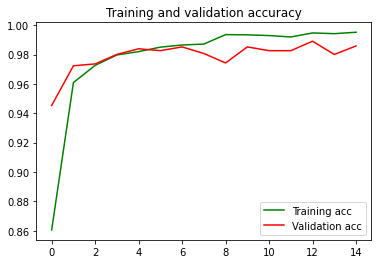

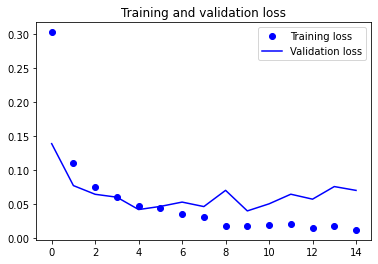

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

20/20 [==============================] - 0s 11ms/step
Accuracy: 0.8413461538461539
Precision: 0.8557457212713936
Recall: 0.8974358974358975
F1-Score: 0.8760951188986232


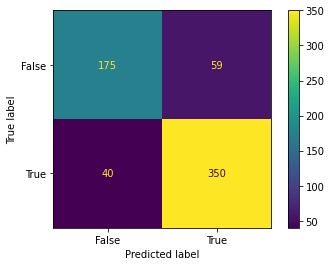

In [ ]:
Y_predict = model.predict(X_test)
show_testing_score(Y_test, Y_predict, True)

# Classification on Dataset including Original + Augmented + Generated Images

In [13]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = load_data('Augmented+Generated')

100%|██████████| 5000/5000 [01:17<00:00, 64.70it/s]


Pneumonia Found: 5000
Normal Found: 5000


100%|██████████| 390/390 [00:03<00:00, 117.69it/s]


Pneumonia Found: 390
Normal Found: 234
Successfully Data loaded...!


In [ ]:
Train_Model_and_Fine_Tune('log(Augmented+Generated)')

61/61 [==============================] - 6s 96ms/step - loss: 0.5362 - accuracy: 0.8380 - val_loss: 0.6315 - val_accuracy: 0.8800
Epoch 2/15
61/61 [==============================] - 6s 91ms/step - loss: 0.1353 - accuracy: 0.9504 - val_loss: 0.5878 - val_accuracy: 0.7115
Epoch 3/15
61/61 [==============================] - 5s 90ms/step - loss: 0.1022 - accuracy: 0.9616 - val_loss: 0.5126 - val_accuracy: 0.8215
Epoch 4/15
61/61 [==============================] - 5s 90ms/step - loss: 0.0834 - accuracy: 0.9680 - val_loss: 0.4570 - val_accuracy: 0.8195
Epoch 5/15
61/61 [==============================] - 6s 90ms/step - loss: 0.0602 - accuracy: 0.9785 - val_loss: 0.3335 - val_accuracy: 0.9265
Epoch 6/15
61/61 [==============================] - 6s 91ms/step - loss: 0.0545 - accuracy: 0.9805 - val_loss: 0.2592 - val_accuracy: 0.9185
Epoch 7/15
61/61 [==============================] - 5s 90ms/step - loss: 0.0396 - accuracy: 0.9866 - val_loss: 0.2113 - val_accuracy: 0.9210
Epoch 8/15
61/61 [======

In [14]:
best_model = ['', 0]
models = []
path = f'{log_path}log(Augmented+Generated)'
for i in tqdm(os.listdir(path)):
  model = tf.keras.models.load_model(f'{path}/{i}')
  accuracy = accuracy_score(Y_test, model.predict(X_test).round())
  if accuracy > best_model[1]:
    best_model = [i, accuracy]
  models.append([i, accuracy])
  model = None

print(f'Best Model: {best_model}')

  0%|          | 0/15 [00:00<?, ?it/s]

20/20 [==============================] - 9s 17ms/step


  7%|▋         | 1/15 [00:16<03:55, 16.83s/it]

20/20 [==============================] - 0s 10ms/step


 13%|█▎        | 2/15 [00:21<02:02,  9.46s/it]

20/20 [==============================] - 0s 11ms/step


 20%|██        | 3/15 [00:25<01:23,  6.93s/it]

20/20 [==============================] - 0s 9ms/step


 27%|██▋       | 4/15 [00:25<00:50,  4.56s/it]

20/20 [==============================] - 0s 10ms/step


 33%|███▎      | 5/15 [00:26<00:31,  3.19s/it]

20/20 [==============================] - 0s 10ms/step


 40%|████      | 6/15 [00:27<00:20,  2.25s/it]

20/20 [==============================] - 0s 11ms/step


 47%|████▋     | 7/15 [00:31<00:22,  2.79s/it]

20/20 [==============================] - 0s 11ms/step


 53%|█████▎    | 8/15 [00:35<00:22,  3.17s/it]

20/20 [==============================] - 0s 10ms/step


 60%|██████    | 9/15 [00:36<00:15,  2.52s/it]

20/20 [==============================] - 0s 10ms/step


 67%|██████▋   | 10/15 [00:37<00:10,  2.04s/it]

20/20 [==============================] - 0s 10ms/step


 73%|███████▎  | 11/15 [00:38<00:06,  1.73s/it]

20/20 [==============================] - 0s 10ms/step


 80%|████████  | 12/15 [00:38<00:04,  1.42s/it]

20/20 [==============================] - 0s 10ms/step


 87%|████████▋ | 13/15 [00:39<00:02,  1.26s/it]

20/20 [==============================] - 0s 9ms/step


 93%|█████████▎| 14/15 [00:40<00:01,  1.14s/it]

20/20 [==============================] - 0s 11ms/step


100%|██████████| 15/15 [00:41<00:00,  2.77s/it]

Best Model: ['neuron-[32, 64]-dense-[]-dropout-[0.5]-bach-True.h5', 0.8477564102564102]


In [15]:
best_model

['neuron-[32, 64]-dense-[]-dropout-[0.5]-bach-True.h5', 0.8477564102564102]

In [17]:
model = define_model([32, 64], [], True, [0.5])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                        

In [18]:
history = model.fit(X_train, Y_train, epochs=15, batch_size=132, validation_data=(X_val, Y_val))

Epoch 1/15
61/61 [==============================] - 9s 109ms/step - loss: 0.5508 - accuracy: 0.8342 - val_loss: 0.6170 - val_accuracy: 0.7890
Epoch 2/15
61/61 [==============================] - 6s 91ms/step - loss: 0.1421 - accuracy: 0.9465 - val_loss: 0.5618 - val_accuracy: 0.7775
Epoch 3/15
61/61 [==============================] - 6s 91ms/step - loss: 0.1071 - accuracy: 0.9604 - val_loss: 0.4778 - val_accuracy: 0.8560
Epoch 4/15
61/61 [==============================] - 6s 91ms/step - loss: 0.0869 - accuracy: 0.9680 - val_loss: 0.3780 - val_accuracy: 0.9295
Epoch 5/15
61/61 [==============================] - 6s 91ms/step - loss: 0.0795 - accuracy: 0.9711 - val_loss: 0.3141 - val_accuracy: 0.9505
Epoch 6/15
61/61 [==============================] - 6s 91ms/step - loss: 0.0630 - accuracy: 0.9775 - val_loss: 0.2682 - val_accuracy: 0.9135
Epoch 7/15
61/61 [==============================] - 6s 91ms/step - loss: 0.0565 - accuracy: 0.9810 - val_loss: 0.1793 - val_accuracy: 0.9500
Epoch 8/15
6

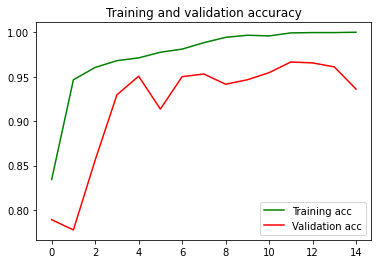

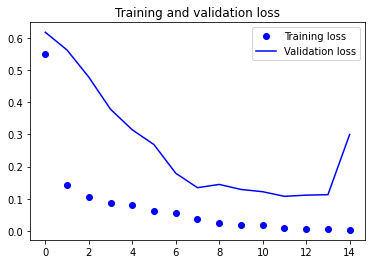

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

20/20 [==============================] - 0s 10ms/step
Accuracy: 0.8605769230769231
Precision: 0.8435374149659864
Recall: 0.9538461538461539
F1-Score: 0.8953068592057761


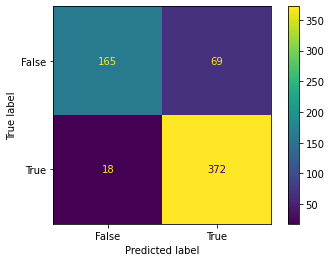

In [21]:
Y_predict = model.predict(X_test)
show_testing_score(Y_test, Y_predict, True)

In [24]:
import pickle

model.save(f'{Dataset_Path}/models/architecure.h5')
model.save_weights(f'{Dataset_Path}/models/weights.h5')
pickle.dump(model, open(f'{Dataset_Path}/models/model.pkl', 'wb'))